# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Задачи: 
- обучить модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности.

- построить модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.



**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

Для выполнения проекта потребуется:
- изучить данные
- очистить текст комментариев от лишних знаков, а также от стоп-слов
- токенизировать текст
- лемматизировать текст
- преобразовать текст в численную форму, то есть произвести векторизацию текста
- разбить данные на тренировочную и тестовые выборки и обучить несколько моделей, выбрать лучшую и убедиться в корректности ее работы на тестовой выборке.

## Подготовка

In [1]:
#pip install spacy
# !{sys.executable} -m spacy download en

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk 
import re
import seaborn as sns
import sys
import spacy

from lightgbm import LGBMClassifier
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

In [3]:
state = np.random.RandomState(12345)

Загрузим из библиотеки nltk стоп-слова для английского языка, так как комментарии в датасете на английском языке:

In [ ]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

Для лемматизации загрузим лексическую базу данных из библиотеки nltk:

In [ ]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

Загрузим и изучим данные: 

In [6]:
try:
    data_toxic = pd.read_csv('/datasets/toxic_comments.csv')
except:
    data_toxic = pd.read_csv('datasets/toxic_comments.csv')

In [7]:
data_toxic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [8]:
pd.set_option('max_colwidth', 200)
data_toxic.head(10)

,Unnamed: 0,text,toxic
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remo...",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about...",0
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tid...",0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0
5,5,"""\n\nCongratulations from me as well, use the tools well. · talk """,0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or you will be banned.",0
8,8,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow they would jump on me for vandalism), I'm merely requesting that it be more encycl...",0
9,9,alignment on this subject and which are contrary to those of DuLithgow,0


In [9]:
data_toxic.duplicated().sum()

0

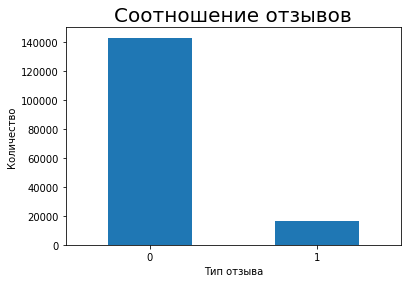

In [10]:
df = data_toxic['toxic'].value_counts()
df.plot(kind='bar', rot=0)
plt.title('Соотношение отзывов', fontsize=20)
plt.xlabel('Тип отзыва')
plt.ylabel('Количество');


**Вывод:** в данных 159292 строчек и 3 столбца. Дубликатов нет. Значительно преобладают положительные отзывы, это необходимо учесть при разделении данных на выборки.

Очистим текст комментариев от лишних знаков и приведем все буквы к нижнему регистру: 

In [11]:
def clear_text(text):
    cleared = re.sub(r'[^A-Za-z]', ' ', text) 
    return (" ".join(cleared.split()))

In [12]:
data_toxic['clear'] = data_toxic.text.str.lower().apply(clear_text)

Проведем лемматизацию с помощью библиотеки nltk, а также токенизируем текст:

In [13]:
lemmatizer = nltk.stem.WordNetLemmatizer()
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_text(text):
    return(' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)]))

In [16]:
data_toxic.to_csv('toxic')

In [17]:
data_toxic

,Unnamed: 0,text,toxic,clear,lemma
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remo...",0,explanation why the edits made under my username hardcore metallica fan were reverted they weren t vandalisms just closure on some gas after i voted at new york dolls fac and please don t remove t...,explanation why the edits make under my username hardcore metallica fan be revert they weren t vandalism just closure on some gas after i vote at new york doll fac and please don t remove the temp...
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,d aww he matches this background colour i m seemingly stuck with thanks talk january utc,d aww he match this background colour i m seemingly stuck with thanks talk january utc
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about...",0,hey man i m really not trying to edit war it s just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about th...,hey man i m really not try to edit war it s just that this guy be constantly remove relevant information and talk to me through edits instead of my talk page he seem to care more about the format ...
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tid...",0,more i can t make any real suggestions on improvement i wondered if the section statistics should be later on or a subsection of types of accidents i think the references may need tidying so that ...,more i can t make any real suggestion on improvement i wonder if the section statistic should be later on or a subsection of type of accident i think the reference may need tidy so that they be al...
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0,you sir are my hero any chance you remember what page that s on,you sir be my hero any chance you remember what page that s on
...,...,...,...,...,...
159287,159446,""":::::And for the second time of asking, when your view completely contradicts the coverage in reliable sources, why should anyone care what you feel? You can't even give a consistent argument - i...",0,and for the second time of asking when your view completely contradicts the coverage in reliable sources why should anyone care what you feel you can t even give a consistent argument is the openi...,and for the second time of ask when your view completely contradicts the coverage in reliable source why should anyone care what you feel you can t even give a consistent argument be the opening o...
159288,159447,You should be ashamed of yourself \n\nThat is a horrible thing you put on my talk page. 128.61.19.93,0,you should be ashamed of yourself that is a horrible thing you put on my talk page,you should be ashamed of yourself that be a horrible thing you put on my talk page
159289,159448,"Spitzer \n\nUmm, theres no actual article for prostitution ring. - Crunch Captain.",0,spitzer umm theres no actual article for prostitution ring crunch captain,spitzer umm there no actual article for prostitution ring crunch captain
159290,159449,And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.,0,and it looks like it was actually you who put on the speedy to have the first version deleted now that i look at it,and it look like it be actually you who put on the speedy to have the first version delete now that i look at it


Определим данные для фичей и таргет. Разделим на выборки для обучения моделей с сохранением соотношения токсичных и нетоксичных комментариев:

In [18]:
features = data_toxic['lemma']
target = data_toxic['toxic']

In [19]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size = 0.1, random_state = state, stratify=target
)

Для векторизации текста воспользуемся методом TF-IDF:

In [20]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords) 
features_tf_idf = count_tf_idf.fit_transform(features_train)
features_test_tf_idf = count_tf_idf.transform(features_test)

**Вывод:**
Мы провели подгтовку текста к дальнейшему обучению моделей классификации: очитили текст, токенизировали, лемматизировали, векторизировали и разделили на тренировочную и тестовую выборки.

## Обучение

Обучим модель линейной регрессии и узнаем усредненную метрику f1_score с помощью метода cross_val_score:

In [21]:
model_lr = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('logreg', LogisticRegression(C=10, class_weight='balanced'))
])
score = cross_val_score(model_lr, features_train, target_train, cv=5, scoring='f1')
print(score.mean())

0.7565819253803647


У линейной регрессии f1_score=0.75.

Подберем параметры для модели дерева решений с помощью класса GridSearchCV:

In [22]:
# model_tree = Pipeline([
#     ('tfidf', TfidfVectorizer()),
#     ('tree', DecisionTreeClassifier(random_state=state, class_weight='balanced'))
# ])

# param_grid = {'tree__max_depth' : [2,4,6,10]}

# grid_search = GridSearchCV(model_tree, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
# grid_search.fit(features_train, target_train)

# print('Наилучший результат метрики {} с параметрами: {}'.format(grid_search.best_score_, grid_search.best_params_))

Наилучший результат метрики DecisionTreeClassifier f1_score=0.50 с параметрами: max_depth=10.

Подберем параметры для модели LGBMClassifier с помощью класса GridSearchCV:

In [23]:
model_light = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('light', LGBMClassifier(random_state=state, class_weight='balanced'))
])

param_grid = {'light__num_iterations' : [500, 1000],
              'light__learning_rate' : [0.01, 0.05, 0.1]
             }

grid_search_light = GridSearchCV(model_light, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search_light.fit(features_train, target_train)

print('Наилучший результат метрики {} с параметрами: {}'.format(grid_search_light.best_score_, grid_search_light.best_params_))

KeyboardInterrupt: 

Наилучший результат метрики LGBMClassifier f1_score=0.87 с параметрами: num_iterations=1000, learning_rate=0.05

In [24]:
model_light = LGBMClassifier(num_iterations=1000, learning_rate=0.05, random_state=state)
model_light.fit(features_tf_idf, target_train)
predictions = model_light.predict(features_test_tf_idf)
print('Значение метрики:', f1_score(target_test, predictions))

Значение метрики: 0.7844084166954122


In [25]:
print(classification_report(target_test, predictions))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     14311
           1       0.89      0.70      0.78      1619

    accuracy                           0.96     15930
   macro avg       0.93      0.85      0.88     15930
weighted avg       0.96      0.96      0.96     15930



На тестовой выборке у модели, построенной по алгоритму LGBMClassifier, мы получили значение метрики f1_score=0,78.

**Вывод:**
Лучшее значение метрики  f1_score=0.87 получилось достичь с помощью обучения модели LGBMClassifier с параметрами: num_iterations=1000, learning_rate=0.05. У модели LogisticRegression f1_score=0.75, самое низкое значение у модели DecisionTreeClassifier f1_score=0.50 с параметром max_depth=10.

Для проверки тестовой выборки выбрана модель с самым высоким значением f1_score, это модель LGBMClassifier. Значение метрики не превысило значения 0,78.

## Выводы

Магазин запускает новый сервис, появилась необходимость в инструменте, который будет искать токсичные комментарии и отправлять их на модерацию.

Целью проекта было обучить модель классифицировать комментарии на позитивные и негативные.

Для обучения моделей потребовалось подготовить текст:
- очищен текст комментариев от лишних знаков, а также от стоп-слов
- токенизирован
- лемматизирован
- преобразован в численную форму для использования обучения моделей алгоритмами: LogisticRegression, DecisionTreeClassifier, LGBMClassifier.

Наилучшее значение метрики f1_score=0.87 получилось достичь с помощью обучения модели LGBMClassifier с параметрами: num_iterations=1000, learning_rate=0.05 на тренировочной выборке, на тестовой выборке f1_score=0.78.